In [283]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon, mapping, shape

import csv
from pathlib import Path

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from rasterstats import zonal_stats

from descartes import PolygonPatch

import geojson

from fiona import collection
import fiona

import geoplot 

from shape_generator import select_raster_file

ImportError: No module named 'shape_generator'

## Setting up the data files

In [276]:
# reading in the Gridded Population of the World dataset
input_raster_file= rasterio.open('/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_15_min_tif/gpw_v4_population_count_rev11_2015_15_min.tif')
print(input_raster_file)

<open RasterReader name='/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_15_min_tif/gpw_v4_population_count_rev11_2015_15_min.tif' mode='r'>


In [141]:
#Explore population tif data
print("count: {}".format(input_filename.count)) # Raster bands
print("height(rows): {}".format(input_filename.height)) # Rows (rows)
print("width(columns): {}".format(input_filename.width)) # Columns

count: 1
height(rows): 720
width(columns): 1440


In [142]:
input_filename.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999983, top=89.99999999999991)

In [143]:
band1 = input_filename.read(1)
band1

array([[-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38],
       [-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38],
       [-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38],
       ...,
       [-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38],
       [-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38],
       [-3.402823e+38, -3.402823e+38, -3.402823e+38, ..., -3.402823e+38,
        -3.402823e+38, -3.402823e+38]], dtype=float32)

In [144]:
{i: dtype for i, dtype in zip(input_filename.indexes, input_filename.dtypes)}

{1: 'float32'}

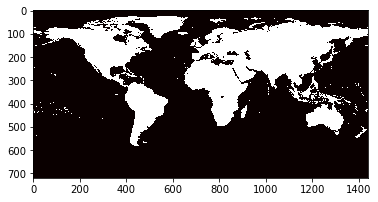

In [145]:
plt.imshow(band1, cmap='hot')

In [146]:
with rasterio.open('/Users/jswee/Documents/OFDA/Data Model/Population Data/gpw-v4-population-count-rev11_2015_15_min_tif/gpw_v4_population_count_rev11_2015_15_min.tif') as src:
    print(src.crs)

#Important to note the CRS - epsg (#https://www.spatialreference.org/ref/epsg/32613/)

CRS({'init': 'epsg:4326'})


In [147]:
# get the countries associated for the geometry boundary's
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,(POLYGON ((141.0002104025918 -2.60015105551566...
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
9,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...


In [148]:
world.crs

{'init': 'epsg:4326'}

In [149]:
# reading in the flood data
df_input = pd.read_csv("/Users/jswee/Documents/OFDA/Data Model/FloodsArchived/FloodArchive.csv")  
df_input

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity
0,1,0,Algeria,0,5.23026,35.814200,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0
1,2,0,Brazil,0,-45.34890,-18.711100,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0
2,3,0,Phillipines,0,122.97400,10.020700,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0
3,4,0,Indonesia,0,124.60600,1.014890,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0
4,5,0,Mozambique,0,32.34910,-25.869300,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0
5,6,0,Comoros islands,0,43.36000,-11.651600,1035.61,2/16/1985,2/28/1985,News,2,35000,Tropical cyclone,1.0
6,7,0,New Zealand,0,175.73400,-37.230500,7871.37,2/17/1985,2/18/1985,News,4,200,Heavy rain,1.0
7,8,0,Indonesia,0,108.14000,-7.040080,77091.11,2/19/1985,2/23/1985,News,10,2000,Heavy rain,1.0
8,9,0,USA,0,-85.17420,40.669100,210527.96,2/22/1985,3/1/1985,News,7,2250,Rain and snowmelt,2.0
9,10,0,Bolivia,0,-63.28870,-21.224400,69706.89,2/25/1985,2/28/1985,News,2,1000,Heavy Rain,1.0


In [150]:
df_input.columns

Index(['ID', 'GlideNumber', 'Country', 'OtherCountry', 'long', 'lat', 'Area',
       'Began', 'Ended', 'Validation', 'Dead', 'Displaced', 'MainCause',
       'Severity'],
      dtype='object')

In [267]:
df_input['Year'] = pd.DatetimeIndex(df_input['Began']).year
df_input.head()

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,point_0,area_radii,year,Year
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,POINT (5.230259999999999 35.8142),171.698816,1985,1985
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,POINT (-45.3489 -18.7111),464.728826,1985,1985
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,POINT (122.974 10.0207),63.945433,1985,1985
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,POINT (124.606 1.01489),72.563905,1985,1985
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,POINT (32.3491 -25.8693),79.952273,1985,1985


In [268]:
#Create list of floods by ID, country and year
floods = df_input.groupby(['ID', 'Country', 'Year'], as_index = False).sum()
floods = floods[['ID','Country', 'Year']]
floods

,ID,Country,Year
0,1,Algeria,1985
1,2,Brazil,1985
2,3,Phillipines,1985
3,4,Indonesia,1985
4,5,Mozambique,1985
5,6,Comoros islands,1985
6,7,New Zealand,1985
7,8,Indonesia,1985
8,9,USA,1985
9,10,Bolivia,1985


In [269]:
#Helper function for getting flood year and country by ID
def get_flood_country_year_by_ID(ID):
    flood_country = floods.loc[floods.ID == ID].Country.values[0]
    flood_year = floods.loc[floods.ID == ID].Year.values[0]
    return flood_country, flood_year   

In [270]:
ID=5

In [273]:
flood_country, flood_year = get_flood_country_year_by_ID(ID)
print (flood_country, flood_year)

Mozambique 1985


In [151]:
#Function to create geometric point of lat/ long for each flood
def create_flood_gdf(df):
    df['point_0'] = df.apply(lambda row: Point(row.long, row.lat), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='point_0') #, crs={'init': 'epsg:4326'})  # deprecated version
    gdf.crs =  "EPSG:4326"
    return gdf

In [152]:
# Create GeoPandasDataFrame for floods

In [153]:
flood_gdf = create_flood_gdf(df_input)
flood_gdf

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,point_0
0,1,0,Algeria,0,5.23026,35.814200,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,POINT (5.230259999999999 35.8142)
1,2,0,Brazil,0,-45.34890,-18.711100,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,POINT (-45.3489 -18.7111)
2,3,0,Phillipines,0,122.97400,10.020700,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,POINT (122.974 10.0207)
3,4,0,Indonesia,0,124.60600,1.014890,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,POINT (124.606 1.01489)
4,5,0,Mozambique,0,32.34910,-25.869300,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,POINT (32.3491 -25.8693)
5,6,0,Comoros islands,0,43.36000,-11.651600,1035.61,2/16/1985,2/28/1985,News,2,35000,Tropical cyclone,1.0,POINT (43.36 -11.6516)
6,7,0,New Zealand,0,175.73400,-37.230500,7871.37,2/17/1985,2/18/1985,News,4,200,Heavy rain,1.0,POINT (175.734 -37.2305)
7,8,0,Indonesia,0,108.14000,-7.040080,77091.11,2/19/1985,2/23/1985,News,10,2000,Heavy rain,1.0,POINT (108.14 -7.040080000000001)
8,9,0,USA,0,-85.17420,40.669100,210527.96,2/22/1985,3/1/1985,News,7,2250,Rain and snowmelt,2.0,POINT (-85.1742 40.6691)
9,10,0,Bolivia,0,-63.28870,-21.224400,69706.89,2/25/1985,2/28/1985,News,2,1000,Heavy Rain,1.0,POINT (-63.2887 -21.2244)


### Some helper functions for plotting

In [154]:
def plot_flood_on_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    fig, ax = plt.subplots(figsize=(15, 15))
    world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

In [155]:
def plot_flood_on_partial_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
 
    fig, ax = plt.subplots()
    #fig, ax = plt.subplots(figsize=(10, 10))
    partial_world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

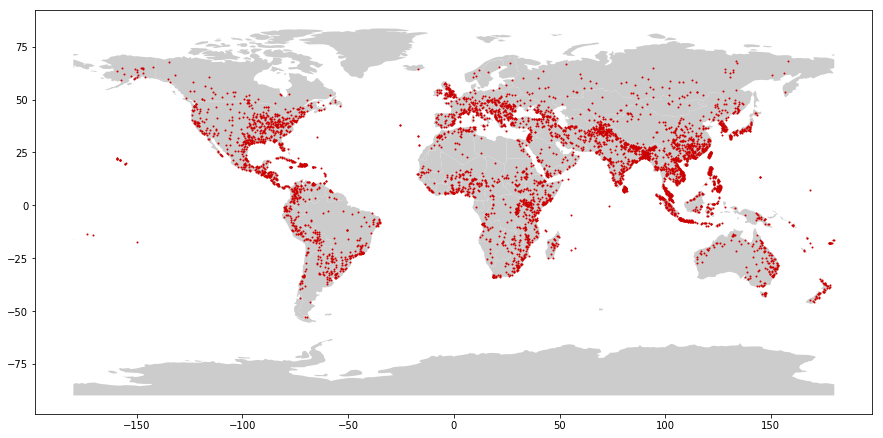

In [156]:
plot_flood_on_worldmap(flood_gdf)

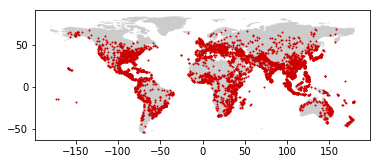

In [157]:
plot_flood_on_partial_worldmap(flood_gdf)

In [158]:
### Create a buffer of the GeoPandasDataFrame according to the area of the given flood
# might need to convert the CRS before calculation

In [159]:
# Area in flood data is square km and input to function is the radii from the point so need to convert to radii
import math
flood_gdf['area_radii']=(flood_gdf['Area']/math.pi)
flood_gdf['area_radii']=flood_gdf['area_radii']**(1/2)
flood_gdf

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,point_0,area_radii
0,1,0,Algeria,0,5.23026,35.814200,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,POINT (5.230259999999999 35.8142),171.698816
1,2,0,Brazil,0,-45.34890,-18.711100,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,POINT (-45.3489 -18.7111),464.728826
2,3,0,Phillipines,0,122.97400,10.020700,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,POINT (122.974 10.0207),63.945433
3,4,0,Indonesia,0,124.60600,1.014890,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,POINT (124.606 1.01489),72.563905
4,5,0,Mozambique,0,32.34910,-25.869300,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,POINT (32.3491 -25.8693),79.952273
5,6,0,Comoros islands,0,43.36000,-11.651600,1035.61,2/16/1985,2/28/1985,News,2,35000,Tropical cyclone,1.0,POINT (43.36 -11.6516),18.156126
6,7,0,New Zealand,0,175.73400,-37.230500,7871.37,2/17/1985,2/18/1985,News,4,200,Heavy rain,1.0,POINT (175.734 -37.2305),50.055318
7,8,0,Indonesia,0,108.14000,-7.040080,77091.11,2/19/1985,2/23/1985,News,10,2000,Heavy rain,1.0,POINT (108.14 -7.040080000000001),156.648851
8,9,0,USA,0,-85.17420,40.669100,210527.96,2/22/1985,3/1/1985,News,7,2250,Rain and snowmelt,2.0,POINT (-85.1742 40.6691),258.868946
9,10,0,Bolivia,0,-63.28870,-21.224400,69706.89,2/25/1985,2/28/1985,News,2,1000,Heavy Rain,1.0,POINT (-63.2887 -21.2244),148.957686


In [191]:
# Multiply by 1000 to convert km to meters - buffering done in meters
def buffer_area(df):
    df['total_area'] = df.apply(lambda x: x.point_0.buffer(x['area_radii']*1000) , axis=1)  
    df = df.set_geometry('total_area')
    return df

In [227]:
buffer_gdf = buffer_area(flood_gdf)
buffer_gdf.head()

,ID,GlideNumber,Country,OtherCountry,long,lat,Area,Began,Ended,Validation,Dead,Displaced,MainCause,Severity,point_0,area_radii,total_area
0,1,0,Algeria,0,5.23026,35.81420,92615.67,1/1/1985,1/5/1985,News,26,3000,Heavy rain,1.0,POINT (5.230259999999999 35.8142),171.698816,"POLYGON ((171704.0461456534 35.8142, 170877.26..."
1,2,0,Brazil,0,-45.34890,-18.71110,678498.82,1/15/1985,2/2/1985,News,229,80000,Heavy rain,2.0,POINT (-45.3489 -18.7111),464.728826,"POLYGON ((464683.4775892079 -18.7111, 462445.6..."
2,3,0,Phillipines,0,122.97400,10.02070,12846.03,1/20/1985,1/21/1985,News,43,444,Torrential rain,1.0,POINT (122.974 10.0207),63.945433,"POLYGON ((64068.40657507577 10.0207, 63760.491..."
3,4,0,Indonesia,0,124.60600,1.01489,16542.12,2/4/1985,2/18/1985,News,21,300,Torrential rain,1.0,POINT (124.606 1.01489),72.563905,"POLYGON ((72688.51117632445 1.01489, 72339.096..."
4,5,0,Mozambique,0,32.34910,-25.86930,20082.21,2/9/1985,2/11/1985,News,19,0,Heavy rain,2.0,POINT (32.3491 -25.8693),79.952273,"POLYGON ((79984.62223478325 -25.8693, 79599.63..."


In [238]:
def create_buffered_shape(buffer_gdf):
    # requires buffer_gdf that was buffered in above function
    buffer_gdf.set_geometry('total_area', inplace=True)
    center_shape = buffer_gdf['total_area'].unary_union
    shape_gdf = GeoDataFrame( geometry = [center_shape])
    return shape_gdf

In [239]:
max_shape= create_buffered_shape(buffer_gdf)
max_shape

,geometry
0,"POLYGON ((1237917.765241841 16.454, 1231956.86..."


In [243]:
def get_buffered_shape(gdf):
    buffer_gdf = buffer_area(gdf)
    buffered_shape = create_buffered_shape(buffer_gdf)
    return buffered_shape

In [245]:
shape = get_buffered_shape(buffer_gdf)
shape.crs = 'epsg:4326'
shape

,geometry
0,"POLYGON ((1237917.765241841 16.454, 1231956.86..."


In [ ]:
## Overlaying the shape of the floods with the shapes of the worlds
### Determine the affected countries for a cyclone depending on the flood shape

In [167]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,(POLYGON ((141.0002104025918 -2.60015105551566...
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
9,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...


In [188]:
#checking geometry types of world and buffer_gdf
world['geometry'].geom_type

0      MultiPolygon
1           Polygon
2           Polygon
3      MultiPolygon
4      MultiPolygon
5           Polygon
6           Polygon
7      MultiPolygon
8      MultiPolygon
9      MultiPolygon
10     MultiPolygon
11          Polygon
12          Polygon
13          Polygon
14          Polygon
15          Polygon
16          Polygon
17          Polygon
18     MultiPolygon
19     MultiPolygon
20          Polygon
21     MultiPolygon
22          Polygon
23          Polygon
24          Polygon
25          Polygon
26          Polygon
27          Polygon
28          Polygon
29          Polygon
           ...     
147    MultiPolygon
148    MultiPolygon
149         Polygon
150         Polygon
151         Polygon
152         Polygon
153         Polygon
154         Polygon
155    MultiPolygon
156         Polygon
157         Polygon
158         Polygon
159    MultiPolygon
160         Polygon
161         Polygon
162         Polygon
163         Polygon
164         Polygon
165         Polygon


In [263]:
buffer_gdf['total_area'].geom_type

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
5       Polygon
6       Polygon
7       Polygon
8       Polygon
9       Polygon
10      Polygon
11      Polygon
12      Polygon
13      Polygon
14      Polygon
15      Polygon
16      Polygon
17      Polygon
18      Polygon
19      Polygon
20      Polygon
21      Polygon
22      Polygon
23      Polygon
24      Polygon
25      Polygon
26      Polygon
27      Polygon
28      Polygon
29      Polygon
         ...   
4920    Polygon
4921    Polygon
4922    Polygon
4923    Polygon
4924    Polygon
4925    Polygon
4926    Polygon
4927    Polygon
4928    Polygon
4929    Polygon
4930    Polygon
4931    Polygon
4932    Polygon
4933    Polygon
4934    Polygon
4935    Polygon
4936    Polygon
4937    Polygon
4938    Polygon
4939    Polygon
4940    Polygon
4941    Polygon
4942    Polygon
4943    Polygon
4944    Polygon
4945    Polygon
4946    Polygon
4947    Polygon
4948    Polygon
4949    Polygon
Length: 4950, dtype: obj

In [247]:
#find overlay of affected countries from floods
affected_countries = gpd.overlay(world, shape, how='intersection')
affected_countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,(POLYGON ((-55.60021826844206 51.3170746933979...
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,(POLYGON ((154.7599906760844 -5.33998381919849...
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
9,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-57.62513342958296 -30.216294854454...


### Get the affected population

In [119]:
def get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed):
    stats = ['sum']
    raster_file = select_raster_file(cyclone_year, input_file)
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['NAME'] = cyclone_name
        cyclone['SEASON'] = cyclone_year
        cyclone['COUNTRY'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   
        cyclone_data.append(cyclone)
    return cyclone_data, raster_file

In [85]:
cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed)
cyclone_data_windspeed

[{'NAME': 'GLORIA',
  'SEASON': 1957,
  'COUNTRY': 'Mozambique',
  'iso_a3': 'MOZ',
  'pop_max_34': 2467098.75},
 {'NAME': 'GLORIA',
  'SEASON': 1957,
  'COUNTRY': 'Madagascar',
  'iso_a3': 'MDG',
  'pop_max_34': 240383.375}]

In [285]:
def get_population_by_ID(ID, affected_countries):
    
    flood_country, flood_year = get_flood_country_year_by_ID(ID)
    
    stats = ['sum']
    raster_file = select_raster_file(flood, input_file)
    flood_data = []
    for i in range (len(affected_countries)):   
        flood = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        flood['ID']= ID
        flood['Country'] = country
        flood['Year'] = flood_year
        flood['iso_a3'] = iso
        flood['pop'] = population   
        flood_data.append(flood)
    return flood_data, raster_file

In [286]:
flood_data, raster_year = get_population_by_ID(ID, affected_countries)
flood_data

NameError: name 'select_raster_file' is not defined

In [91]:
# Combining the different outputs into a single dataframe
cyclone_pop_df = pd.DataFrame(cyclone_data_windspeed)
data = cyclone_pop_df.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()
data

,SID,NAME,SEASON,COUNTRY,pop_max_34
0,1949163N07145,DELLA,1949,Madagascar,240383.375
1,1949163N07145,DELLA,1949,Mozambique,2467098.750


## Summary of the code above for a single cyclone and a single windspeed

In [92]:
SID = '2019068S17040'
windspeed = 'max_34'
#windspeed = 'max_50'
#windspeed = 'max_64'
cyclone_df = df_input[(df_input.SID == SID)].copy()
single_cyclone_df= create_shifted_dataset(cyclone_df)
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
shape = get_buffered_shape(cyclone_gdf, windspeed)
shape.crs = 'epsg:4326'
affected_countries = gpd.overlay(world, shape, how='intersection')
cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID, affected_countries, windspeed)
cyclone_data_windspeed

[{'SID': '2019068S17040',
  'NAME': 'IDAI',
  'SEASON': 2019,
  'COUNTRY': 'Mozambique',
  'iso_a3': 'MOZ',
  'pop_max_34': 2467098.75},
 {'SID': '2019068S17040',
  'NAME': 'IDAI',
  'SEASON': 2019,
  'COUNTRY': 'Madagascar',
  'iso_a3': 'MDG',
  'pop_max_34': 240383.375}]

### Creating a function to get all the information for a single cyclone

In [93]:
def get_population_by_cyclone(cylone_name, cyclone_year):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.SEASON==cyclone_year) & (df_input.NAME == cyclone_name)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [94]:
cyclone_year = 1950
cyclone_name = 'JANE'
example_pop, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
print(raster_year)
print(example_pop)

[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 43343320.0}]
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 21380746.0}]
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 13972339.0}]
G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 43343320.0}, {'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 21380746.0}, {'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 13972339.0}]


In [95]:
def get_population_by_ID(ID):    
    single_flood_data = []
    flood_df = df_input[(df_input.ID==ID)].copy()
    single_flood_df= create_shifted_dataset(flood_df)
    flood_gdf = create_flood_gdf(single_flood_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(flood_gdf)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [96]:
SID = '1949163N07145'
example_pop, raster_year = get_population_by_SID(SID)
print(raster_year)
print(example_pop)

[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'South Korea', 'iso_a3': 'KOR', 'pop_max_34': 26485.90234375}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 16431894.0}]
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 7958809.0}]
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 4553851.0}]
G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'South Korea', 'iso_a3': 'KOR', 'pop_max_34': 26485.90234375}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 16431894.0}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'J

In [ ]:
## Creating population data for all floods

In [249]:
flood_data = []
error_flood = []
#for i in range (10):                  
for i in range (len(df_input)):             ## Change here to get output for all cyclones
    flood = {}
    flood_ID = (df_input.iloc[i]['ID'])
    flood_country = (df_input.iloc[i]['Country'])
    flood_area = (df_input.iloc[i]['Area'])
    print(f'{i}/{len(df_input)} Getting population for:{flood_ID}-{flood_country}-{flood_area}')
    try:
        cyclone_population, raster_year = get_population_by_SID(cyclone_SID)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()

SyntaxError: invalid syntax (<ipython-input-249-835d6a4e1ae0>, line 9)

In [102]:
summary_df

,SID,NAME,SEASON,COUNTRY,pop_max_34,pop_max_50,pop_max_64
0,1949163N07145,DELLA,1949,Japan,1.643189e+07,7.958809e+06,4.553851e+06
1,1949163N07145,DELLA,1949,South Korea,2.648590e+04,0.000000e+00,0.000000e+00
2,1950241N23140,JANE,1950,Japan,4.334332e+07,2.138075e+07,1.397234e+07
3,1951224N12316,CHARLIE,1951,Dominican Rep.,6.813668e+02,0.000000e+00,0.000000e+00
4,1951224N12316,CHARLIE,1951,Haiti,3.154269e+05,0.000000e+00,0.000000e+00
5,1951224N12316,CHARLIE,1951,Jamaica,2.753688e+06,2.750167e+06,1.948091e+06
6,1951224N12316,CHARLIE,1951,Mexico,8.146825e+06,3.535850e+06,2.489068e+06
7,1951337N09150,AMY,1951,Philippines,1.413200e+07,8.926450e+06,3.309632e+06
8,1952180N05144,EMMA,1952,China,1.854397e+07,4.845178e+06,2.775118e+06
9,1952180N05144,EMMA,1952,Philippines,1.523273e+07,8.281656e+06,5.903694e+06


In [ ]:
summary_df.to_pickle("../data/population_by_cyclone_sm_v3.pkl")

## Check cyclones that caused geometric errors

In [ ]:
error_cyclone

### Saving the dataframe

In [ ]:
unpickled = pd.read_pickle("../data/population_by_cyclone_sm_v3.pkl")
unpickled

In [ ]:
unpickled.to_csv("../data/population_by_cyclone_sm_v3.csv")

# Old versions of code

In [ ]:
cyclone_data = []
error_cyclone = []
for i in range (10):                  
#for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_name = (cyclones.iloc[i]['name'])
    cyclone_year = (cyclones.iloc[i]['year'])
    print(f'{i}/{len(cyclones)} Getting population for {cyclone_name} - {cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['name','year', 'country'], as_index = False).sum()
summary_df

In [ ]:
## Create a bffer of the GeoPandas Dataframe according to area of given flood using azimuthal equidistant projection

#from functools import partial
#import pyproj
#from shapely.ops import transform
#from shapely.geometry import Point

#proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')


#def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    #aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    #project = partial(
        #pyproj.transform,
        #pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        #proj_wgs84)
    #buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    #return transform(project, buf).exterior.coords[:]
# Example
#b = geodesic_point_buffer(45.4, -75.7, 100.0)
#b